In [14]:
import pandas as pd 
import numpy as np
import sys
from spacy_download import load_spacy
from datetime import datetime
import time
from fredapi import Fred
from datetime import datetime

sys.path.append('../')
import config
fred = Fred(api_key=config.api_key)

df = pd.read_csv('monpol_minutes_DB.csv')

#Fix up the dates
format_string = "%A %d de %B de %Y"
import locale
locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')
df['date'] = df['date'].apply(lambda x: x.replace("\n", ""))
df['date'] = df['date'].apply(lambda x: x.strip())
df['datetime'] = df['date'].apply(lambda x: datetime.strptime(x, format_string))
df['datetime'] = df['datetime'].apply(lambda x: datetime(x.year, x.month, 1))

df = df.set_index('datetime')

df = df[['headline','content']]

In [ ]:
from textblob import TextBlob
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

# sample text
df['positive'] = 0
df['negative'] = 0
df['neutral'] = 0

for i in range (0,19):
    text = df.iloc[i,1]
    #initiate textblog object
    
    # Perform sentiment analysis on the text
    sentiment = analyzer.predict(text)
    
    # Print the sentiment scores
    df.iloc[i,2] = sentiment.probas['POS']
    df.iloc[i,3] = sentiment.probas['NEG']
    df.iloc[i,4] = sentiment.probas['NEU']


In [16]:
#Define function for collecting data from FRED
def fredget(varlist, start_date, end_date, plots=True,freq="",name_map = dict()):
    df_collect = pd.DataFrame()

    for var in varlist:
        df_add = fred.get_series(var, observation_start = start_date, observation_end=end_date, frequency =freq).to_frame(name = var)
        info_add = fred.get_series_info(var).to_frame(name = var)
        print(var)
        #If user changes the 
        if freq != "":
            info_add.loc['cur_freq', var] = freq
            
        if var in name_map:
            info_add.loc['user_title', var] = name_map[var]
        else:
            info_add.loc['user_title', var] = info_add.loc['title', var]
                    
        if plots == True:
            df_add.plot(y=var, use_index=True, kind='line', title = info_add.loc['user_title', var], ylabel = info_add.loc['units', var] )
            
        if df_collect.empty == True:
            df_collect = df_add
            info_store = info_add
        else:
            df_collect = pd.merge(df_collect, df_add, left_index=True, right_index=True, how='outer')
            info_store = pd.merge(info_store, info_add, left_index=True, right_index=True, how='left')
            
    df_collect.sort_index()
    return df_collect, info_store


#Define FRED codes to search for 
FRED_list = ['CPALTT01CLM657N','CPGREN01CLM657N','CPGRLE01CLM657N','WPUID61','PCOPPUSDM','BAA10Y','VIXCLS','CUSR0000SAD','CCUSSP02CLM650N']
s_d ='2020-01-01'
e_d='2023-03-01'

#Collect variables into a monthly df
df_collect_m, dfinfo_m = fredget(FRED_list, s_d, e_d, freq = "m", plots=False)
#Convert this series to MoM % changes
df_collect_m['WPUID61'] = df_collect_m['WPUID61'].pct_change(3)*100
df_collect_m['PCOPPUSDM'] = df_collect_m['PCOPPUSDM'].pct_change(3)*100
rename_cols = {"CPALTT01CLM657N":"CPI","CPGREN01CLM657N":"energy","CPGRLE01CLM657N":"CORE","WPUID61":"USppi","PCOPPUSDM":"copper","CLP=X":"exrate","CL=F":"oil","CUSR0000SAD":"goods",'CCUSSP02CLM650N':'CLPUSD'}
df_collect_m = df_collect_m.rename(columns=rename_cols)
df = df.merge(df_collect_m, how='inner',left_index=True,right_index=True)

CPALTT01CLM657N
CPGREN01CLM657N
CPGRLE01CLM657N
WPUID61
PCOPPUSDM
BAA10Y
VIXCLS
CUSR0000SAD
CCUSSP02CLM650N


Text(0.5, 1.0, 'Chile: Evolution of Monetary Policy Minutes Sentiment (Late 2020 -> Present)')

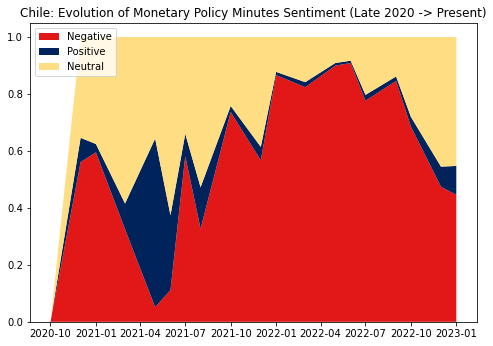

In [17]:
import matplotlib.pyplot as plt
colpal = ['E21818', '00235B','FFDD83' ]
fig = plt.figure(figsize = (8, 5.5))
plt.stackplot(df.index,  df["negative"], df["positive"], df["neutral"], labels=['Negative','Positive','Neutral'],colors=colpal)
plt.legend(loc='upper left')
plt.title('Chile: Evolution of Monetary Policy Minutes Sentiment (Late 2020 -> Present)')

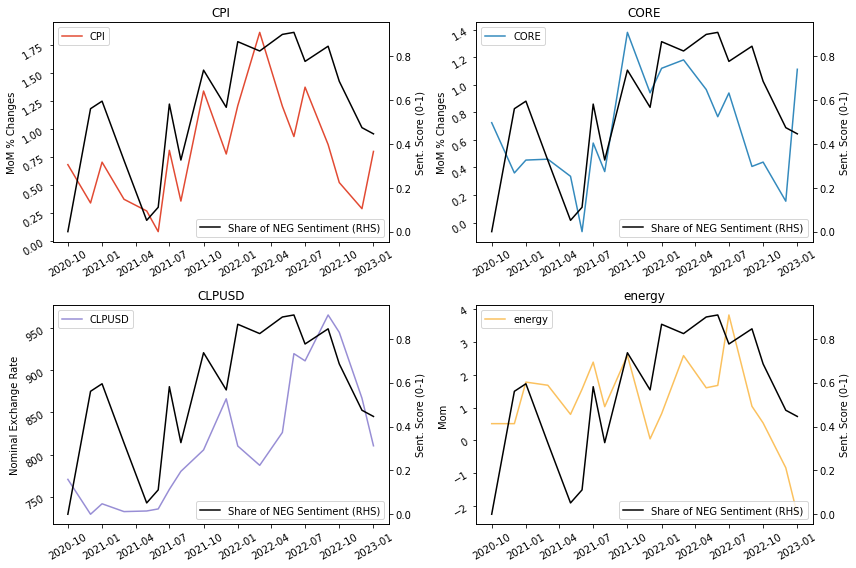

In [42]:
#Plot Negative sentiment vs. Relevanrt covariates
fig, axs = plt.subplots(2,2, figsize = (12, 8))

#Plot index variable
col = 0
row = 0
colorlist = ['#E24A33','#348ABD','#988ED5','#FBC15E','#8EBA42','#FFB5B','#777777']

cov_list = {'CPI':'MoM % Changes','CORE':'MoM % Changes','CLPUSD':'Nominal Exchange Rate','energy':'Mom'}
for i, var in enumerate(cov_list):
    
    fig.tight_layout()
   
    #chart Indexing
    if i == 2:
        row = 1
        col = 0
        
    #Define plots here 
    axs[row,col].set_title(var)
    axs[row,col].tick_params(rotation=30)
    axs[row,col].plot(df[var],color = colorlist[i],label =var)
    axs[row,col].legend(loc='upper left')
    axs[row,col].set_ylabel(cov_list[var])
    ax2 = axs[row,col].twinx()
    
    ax2.plot(df['negative'],'k',label ='Share of NEG Sentiment (RHS)')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('Sent. Score (0-1)')
    
    
    col += 1
    

            



In [19]:
nlp = spacy.load("es_core_news_sm")

for i in range (0,10):
    text = df.iloc[i,4]
    
    doc = nlp(text)
    # Extract key named entities
    named_entities = [ent.text for ent in doc.ents]

    # Extract key noun phrases
    noun_chunks = [chunk.text for chunk in doc.noun_chunks]

    # Print the results
    #print("Named entities:", named_entities)
    print("Noun chunks:", noun_chunks)

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'numpy.float64'>